# 1 Dimensional model of tempreture diffusion 
$$
\frac{\partial u(x,t)}{\partial t} = c_p \frac{\partial^2 u(x,t)}{\partial x^2}$$




## Library imports

In [225]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

## PINN definition
Here we define classical architecture of PINN that is a feed forward fully connected neural network with tanh() activation function

In [226]:
class termPINN_1D(nn.Module):
    def __init__(self, num_hidden = 256, num_layers = 10):
        super(termPINN_1D, self).__init__()
        layers = []
        # Input: x,t
        layers.append(nn.Linear(2, num_hidden))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_hidden,1))
        self.net = nn.Sequential(*layers)
        
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.xavier_normal_(m.weight)
    #             nn.init.zeros_(m.bias)   
                
    def forward(self, x):
        return self.net(x)

## Definition of collocation points

In [227]:
def generate_collocation_points(Nx=2**8, Nt = 2**8):
    x = torch.linspace(-1,1, Nx)
    t = torch.linspace(0,1,Nt)
    X, T = torch.meshgrid(x,t, indexing='ij')
    points = torch.stack([X.flatten(), T.flatten()], dim=-1)
    points.requires_grad_(True)
    return points, x,t 

## Define Partial Differential Equation

In [228]:
def derivative(x,y):
    df = torch.autograd.grad(x,y, grad_outputs=torch.ones_like(x).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_t = df[:, 1:2]
    return df_x, df_t

def PDE(model, cp , points):
    Temp = model(points)
    dT_x, dT_t = derivative(Temp, points)
    dT_xx, _ = derivative(dT_x, points)
    pde = 1*(cp*dT_xx - dT_t)
    return pde

def PDE_with_source(model, cp, points, t):
    pulse_pos = [0.10, 0.45, 0.80]
    pump = torch.zeros_like(points)
    for center in pulse_pos:
        pump += torch.exp(-(t-center)**2/0.0005)
    pump /= torch.max(pump)
    pump = pump.to(device)
    
    Temp = model(points)
    dT_x, dT_t = derivative(Temp, points)
    dT_xx, _ = derivative(dT_x, points)
    pde = 1*(cp*dT_xx - dT_t) + pump[points]
    return pde

## Dirichlet conditions
def BC_right(model, right_border):
    return model(right_border)
    
def BC_left(model, left_border):
    return model(left_border)    
    
def IC(model, points):
    return model(points)

def compute_bc_ic_loss(model, bc_left_pt, bc_left_value, bc_right_pt, bc_right_value, ic_pt, ic_value):
    term1 = torch.mean((BC_right(model, bc_right_pt)[:,0] - bc_right_value)**2)
    term2 = torch.mean((BC_left(model, bc_left_pt)[:,0] - bc_left_value)**2)
    term3 = torch.mean((IC(model, ic_pt) - ic_value)**2)
    return term1 + term2 + 1000*term3 

    

## Define border and initial conditions

In [229]:
domain, x,t = generate_collocation_points(Nx=2**8, Nt=2**8)
domain = domain.to(device)
bc_right_pt = domain[domain[:,0] == -1].requires_grad_(True)
bc_left_pt = domain[domain[:,0] == 1].requires_grad_(True)
ic_pt = domain[domain[:,1] == 0].requires_grad_(True)
sigma = 0.01
ic_shift = 0.30
signal = torch.exp(-(ic_pt-ic_shift)**2/sigma) + torch.exp(-(ic_pt+ic_shift)**2/sigma)
# 
# pulse_pos = [0.10, 0.45, 0.80]
# pump = torch.zeros_like(t)
# for center in pulse_pos:
#     pump += torch.exp(-(t-center)**2/0.0005)
# pump /= torch.max(pump)
# pump = pump.to(device)
# # plt.plot(pump.detach().cpu().numpy())
# # print(torch.exp(-(domain[:,0]**2)/0.01))
# field = torch.exp(-(domain[:,0]**2)/0.01).reshape(2**8, 2**8)*pump
# 
# 
# plt.scatter(domain[:,0].detach().cpu().numpy(), domain[:,1].detach().cpu().numpy(), c= field.detach().cpu().numpy(), cmap = 'jet')
# 
# # plt.imshow(field.cpu().detach().cpu().numpy(), aspect = 'auto')
#     
# 
# def create_interpolated_function(X, Y, Z):
#     """
#     Create a function that interpolates values from a 2D grid at given coordinates.
#     
#     Parameters:
#     - X: 2D tensor, x-coordinates of the meshgrid (shape: m x n)
#     - Y: 2D tensor, y-coordinates of the meshgrid (shape: m x n)
#     - Z: 2D tensor, function values at meshgrid points (shape: m x n)
#     
#     Returns:
#     - A callable function that takes a 2xN tensor of coordinates and returns interpolated values.
#     """
#     # Ensure Z is in the correct shape for grid_sample: (batch, channels, height, width)
#     Z = Z.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, m, n)
#     
#     # Get min and max for normalization
#     x_min, x_max = X.min(), X.max()
#     y_min, y_max = Y.min(), Y.max()
#     
#     def interpolate(coords):
#         """
#         Interpolate function values at given coordinates.
#         
#         Parameters:
#         - coords: 2xN tensor, where first row is x-coordinates, second row is y-coordinates
#         
#         Returns:
#         - Tensor of interpolated values (shape: N)
#         """
#         # Normalize coordinates to [-1, 1] for grid_sample
#         x_norm = (coords[0] - x_min) / (x_max - x_min) * 2 - 1
#         y_norm = (coords[1] - y_min) / (y_max - y_min) * 2 - 1
#         # Stack and reshape grid to [1, 1, N, 2] for grid_sample
#         grid = torch.stack([x_norm, y_norm], dim=-1).unsqueeze(1)  # Shape: (1, 1, N, 2)
#         
#         # Perform bilinear interpolation
#         interpolated = F.grid_sample(Z, grid, mode='bilinear', align_corners=True)
#         return interpolated.squeeze()  # Shape: (N,)
#     
#     return interpolate
# 
# # Example usage
# # Create a sample meshgrid
# x = torch.linspace(-1, 1, 10)
# y = torch.linspace(-1, 1, 10)
# X, Y = torch.meshgrid(x, y, indexing='ij')
# Z = torch.sin(X) * torch.cos(Y)  # Example function values
# 
# # Create the interpolation function
# f = create_interpolated_function(X, Y, Z)
# 
# # Test with a 2xN tensor of coordinates
# test_coords = torch.tensor([[0.5, -0.5, 0.0], [0.5, -0.5, 0.0]])
# values = f(test_coords)
# print("Interpolated values:", values)






## Training PINN

In [230]:
model = termPINN_1D(2,10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoches = 10000
loss_eval = []
for epoch in range(epoches):
    optimizer.zero_grad()
    pde_residual = PDE(model, 0.1, domain)
    pde_loss = torch.mean(pde_residual**2)
    bc_ic_loss = compute_bc_ic_loss(model, bc_left_pt, 0, bc_right_pt, 0, ic_pt, signal)
    loss = pde_loss + bc_ic_loss
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_eval.append(loss.item())

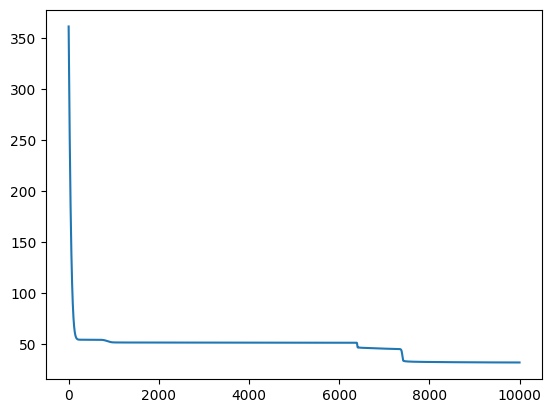

In [231]:
plt.plot(loss_eval)

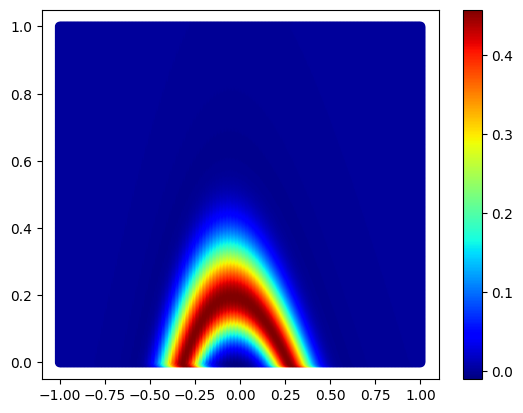

In [232]:
temp_dist = model(domain)
# temp_dist.reshape(100, 2**8)
plt.scatter(domain[:,0].detach().cpu().numpy(), domain[:,1].detach().cpu().numpy(), c= temp_dist.detach().cpu().numpy(), cmap = 'jet')
plt.colorbar()




# plt.imshow(temp_dist.detach().numpy(), aspect='auto', cmap = 'jet')
# print(len(temp_dist))
# plt.plot(temp_dist[:10000000000].detach().numpy())# plt.imshow(temp_dist.detach().numpy(), aspect='auto')

In [233]:
print(bc_right_pt)

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0039],
        [-1.0000,  0.0078],
        [-1.0000,  0.0118],
        [-1.0000,  0.0157],
        [-1.0000,  0.0196],
        [-1.0000,  0.0235],
        [-1.0000,  0.0275],
        [-1.0000,  0.0314],
        [-1.0000,  0.0353],
        [-1.0000,  0.0392],
        [-1.0000,  0.0431],
        [-1.0000,  0.0471],
        [-1.0000,  0.0510],
        [-1.0000,  0.0549],
        [-1.0000,  0.0588],
        [-1.0000,  0.0627],
        [-1.0000,  0.0667],
        [-1.0000,  0.0706],
        [-1.0000,  0.0745],
        [-1.0000,  0.0784],
        [-1.0000,  0.0824],
        [-1.0000,  0.0863],
        [-1.0000,  0.0902],
        [-1.0000,  0.0941],
        [-1.0000,  0.0980],
        [-1.0000,  0.1020],
        [-1.0000,  0.1059],
        [-1.0000,  0.1098],
        [-1.0000,  0.1137],
        [-1.0000,  0.1176],
        [-1.0000,  0.1216],
        [-1.0000,  0.1255],
        [-1.0000,  0.1294],
        [-1.0000,  0.1333],
        [-1.0000,  0